In [1]:
""" 
The algorithm is tested on the PDSystemEnv  gym task 
and developed with Tensorflow

Author: Daniel Salgado Rojo
"""

import tensorflow as tf
import numpy as np
import gym
import gym_pdsystem
from gym import wrappers
#import tflearn
import argparse
import pprint as pp

#from ddpg.replay_buffer import ReplayBuffer

from datetime import datetime

import random

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc


from matplotlib import animation, rc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import HTML


import pandas as pd
import time

from functools import partial

import os

#TO OMMIT WARNINGS
import warnings
warnings.filterwarnings('ignore')

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)   

/home/dsalgador/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# System's parmeters

In [2]:
# In order to change the parameters of the system, such as number of shops, trucks, etc, one must change
# the corresponding constants in the 'constants.py' file from the 'gym pd_system' package.

CASE = ct.CASE
STOCHASTIC = ct.STOCHASTIC 

###########################################################

TANK_MAX_LOADS = ct.TANK_MAX_LOADS
LEVEL_PERCENTAGES = ct.LEVEL_PERCENTAGES 
TRUCK_MAX_LOADS = ct.TRUCK_MAX_LOADS
GRAPH_WEIGHTS = ct.GRAPH_WEIGHTS 
DISCRETE = ct.DISCRETE

n = len(TANK_MAX_LOADS)
k = len(TRUCK_MAX_LOADS)

env = gym.make("PDSystemEnv-v0")
episode_length = 30
env._max_episode_steps = episode_length

###########################################################

print("System with k={} trucks and n={} shops. Episodes of {} days.".format(k,n,episode_length))

System with k=2 trucks and n=5 shops. Episodes of 30 days.


In [3]:
import utils_pg
from utils_pg import int_to_action
from utils_pg import action_to_int
from utils_pg import discount_rewards
from utils_pg import normalize_rewards

# Tensorflow graph (DNN) for MC Policy Gradient Algorithm

In [4]:
simulation_id = 316

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
models_dir = simulation_directory + '/NN-models'

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(models_dir)
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["iteration", "discreward"]], fmt="%s", delimiter=',')

Exception: The simulation id you tried to use has been already used before. Try to change it to a new one.

In [5]:
seed = 42
reset_graph(seed)

################################
# TensorBoard summary directories
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)   
################################

## DNN hyperparameters ################
learning_rate = 0.01 #0.01

hidden1_neurons = 100 #100
hidden2_neurons = 50 #50

# batch_normalization = True  
# batch_norm_momentum = 0.9
######################################



######################################
#### Training hyperparameters ########
######################################
# File names for the model

model_file = models_dir + "/pdenv_policy_net_pg.ckpt"#.format(learning_rate)
best_model_file = models_dir + "/pdenv_best_policy_net_pg.ckpt"#.format(learning_rate)
graph_file =  '{}.meta'.format(model_file)


# Simulation / Training parameters
n_games_per_update = 10
n_max_steps = episode_length
n_iterations = 10**5 #2*10**4
save_iterations = 100 # USEFUL WHEN USING EARLY STOPPING
discount_rate = 0.9

info_freq = 100 #100
round_time = 2
round_reward = 6
summary_freq = 20#int(info_freq/2), 10

# Early stopping
max_checks_without_progress = np.inf # 10,  one for each "info_freq" (in terms of iterations it would be
                                                            #max_checks_without_progress *  info_freq)
checks_without_progress = 0
best_reward = -np.infty


retrain = False
########################################



###### TENSORFLOW GRAPH #########
tf.set_random_seed(seed)
with tf.name_scope("dnn"):
        
            # 1. Parameters to determine the NN architecture

            n_inputs = env.observation_space.shape[1]
            n_hidden1 = hidden1_neurons; activation1 = tf.nn.sigmoid#tf.nn.elu
            n_hidden2 = hidden2_neurons; activation2 = tf.nn.sigmoid#tf.nn.elu
            n_outputs = env.action_space.shape[1]**env.action_space.shape[0]
            
            he_init = tf.contrib.layers.variance_scaling_initializer(seed = seed)

            X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = "X")
            
                    
            hidden1 = tf.layers.dense(X, n_hidden1, activation = activation1,
                                     kernel_initializer = he_init)
            hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = activation2,
                                     kernel_initializer = he_init)
            logits = tf.layers.dense(hidden2, n_outputs, name = "logits"
                                     ,kernel_initializer = he_init)
            
            outputs = tf.nn.softmax(logits)
                   
            
with tf.name_scope("action"):
            # 3. Select a random action (where to go) based on the estimated probabilities
            action = tf.multinomial(tf.log(outputs), num_samples = 1)
            test_action = tf.argmax(outputs, axis = 1)
  
            y = tf.reshape(action, [1])
            
with tf.name_scope("loss"):
            xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,logits = logits)
            loss = tf.reduce_mean(xentropy, name = "loss")
            
tf.summary.scalar('average_cross_entropy', loss)


with tf.name_scope("train"):
            # Optimization Op
            optimizer = tf.train.AdamOptimizer(learning_rate)
            
            grads_and_vars = optimizer.compute_gradients(xentropy)
            gradients = [grad for grad, variable in grads_and_vars]
            gradient_placeholders = []
            grads_and_vars_feed = []
            for grad, variable in grads_and_vars:
                gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
                gradient_placeholders.append(gradient_placeholder)
                grads_and_vars_feed.append((gradient_placeholder, variable))
            training_op = optimizer.apply_gradients(grads_and_vars_feed)
                        
                                       
merged = tf.summary.merge_all()
init = tf.global_variables_initializer()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
        
saver = tf.train.Saver()
        

Instructions for updating:
Use the retry module or similar alternatives.


# PG Training

In [6]:
# with tf.Session() as sess:
    
#     #train_writer = tf.summary.FileWriter(logdir + '/pgtrain', sess.graph)
#     if retrain:
#         saver.restore(sess, model_file)
        
#     summary2 = tf.Summary()
#     if not retrain:
#         init.run()
#     time_start = time.time()

#     for iteration in range(n_iterations+1):
#         print("\rIteration: {}".format(iteration), end="")
#         all_rewards = []
#         all_gradients = []
#         for game in range(n_games_per_update):
#             current_rewards = []
#             current_gradients = []
#             obs = env.reset()
#             for step in range(n_max_steps):
#                 action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)}) 
#                 #print(action_val)
#                 vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
#                 #print(vect_action)
#                 obs, reward, done, info = env.step(vect_action)
#                 current_rewards.append(reward)
#                 current_gradients.append(gradients_val)                
                
#                 if done:
#                     break
#             all_rewards.append(current_rewards)
#             all_gradients.append(current_gradients)
            
        
#         all_disc_rewards =  [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
#         all_disc_norm_rewards = normalize_rewards(all_disc_rewards)     

#         feed_dict = {}
#         for var_index, gradient_placeholder in enumerate(gradient_placeholders):
#             mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
#                                       for game_index, rewards in enumerate(all_disc_norm_rewards)
#                                           for step, reward in enumerate(rewards)], axis=0)
#             feed_dict[gradient_placeholder] = mean_gradients
         
       
#         #tf.summary.scalar('avg_rewards', avg_rewards)
#         #train_writer.add_summary(avg_rewards, iteration)

#         # Summary and info printings     ###################################################################
#         if iteration % info_freq == 0 or iteration % summary_freq == 0:  
            
#             #avg_rewards =np.array([np.mean(np.array(all_rewards)) / n_games_per_update])
#             avg_rewards =np.mean(np.array(all_disc_rewards)) / n_games_per_update
# #             print(avg_rewards)
#             #avg_rewards_list.append(avg_rewards)
#             if iteration % summary_freq == 0:
#                 summary2.value.add(tag='average_reward_per_game', simple_value = avg_rewards)
#                 file_writer.add_summary(summary2, iteration)

#                 feed_dict[X] = obs.reshape(1, n_inputs)
#                 summary = sess.run(merged, feed_dict= feed_dict)

#                 file_writer.add_summary(summary, iteration)
                
#                   # Disc rewards, etc ####
       
#                 with open(rewards_file,'ab') as f:
#                             np.savetxt(f, [np.array([iteration,  avg_rewards])], fmt=("%d",'%.10f'), delimiter=',') 

#             if iteration % info_freq == 0:
#                 time_end = time.time()
#                 print(". Average reward per game: ",  round(avg_rewards, round_reward), 
#                       ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
                
                
#         ###########################################################################      
                
#         if avg_rewards > best_reward:
#                     saver.save(sess, best_model_file)
#                     print("Saved Model with average discounted rewards per game ", avg_rewards)
#                     best_reward = avg_rewards
#                     checks_without_progress = 0
#         else:
#                     checks_without_progress += 1
#                     if checks_without_progress > max_checks_without_progress:
#                         print("Early stopping!")
#                         break
#         ####################################################################################################
#         if iteration % save_iterations == 0:
#                  saver.save(sess, model_file)
        
#         sess.run(training_op, feed_dict=feed_dict)
    
#     #saver.save(sess, model_file + "final")
#     file_writer.flush()
#     file_writer.close()
                 
#     time_end = time.time()
#     print("Simulation finished. Elapsed time ", round( (time_end-time_start)/60., round_time), " minutes.") 
        

Iteration: 0. Average reward per game:  -1.795122 , Elapsed time  0.01  minutes.
Saved Model with average discounted rewards per game  -1.7951215322025764
Iteration: 20Saved Model with average discounted rewards per game  -1.0228992899020877
Iteration: 40Saved Model with average discounted rewards per game  -0.6538184591182701
Iteration: 80Saved Model with average discounted rewards per game  -0.49433794357862315
Iteration: 100. Average reward per game:  -0.371422 , Elapsed time  0.4  minutes.
Saved Model with average discounted rewards per game  -0.37142248107452686
Iteration: 120Saved Model with average discounted rewards per game  -0.33200017476654414
Iteration: 140Saved Model with average discounted rewards per game  -0.3113756720360374
Iteration: 160Saved Model with average discounted rewards per game  -0.23742684090029362
Iteration: 200. Average reward per game:  -0.20915 , Elapsed time  0.83  minutes.
Saved Model with average discounted rewards per game  -0.20915005523428074
Ite

Iteration: 7500. Average reward per game:  -0.085644 , Elapsed time  57.3  minutes.
Iteration: 7600. Average reward per game:  -0.088293 , Elapsed time  58.06  minutes.
Iteration: 7700. Average reward per game:  -0.071829 , Elapsed time  58.88  minutes.
Iteration: 7800. Average reward per game:  -0.08892 , Elapsed time  59.58  minutes.
Iteration: 7900. Average reward per game:  -0.106274 , Elapsed time  60.35  minutes.
Iteration: 7920Saved Model with average discounted rewards per game  -0.05734511330421512
Iteration: 8000. Average reward per game:  -0.05029 , Elapsed time  61.17  minutes.
Saved Model with average discounted rewards per game  -0.05028986179844893
Iteration: 8100. Average reward per game:  -0.071234 , Elapsed time  61.98  minutes.
Iteration: 8200. Average reward per game:  -0.106966 , Elapsed time  62.62  minutes.
Iteration: 8300. Average reward per game:  -0.100375 , Elapsed time  63.38  minutes.
Iteration: 8400. Average reward per game:  -0.067431 , Elapsed time  64.1

Iteration: 16300. Average reward per game:  -0.072453 , Elapsed time  138.08  minutes.
Iteration: 16400. Average reward per game:  -0.048238 , Elapsed time  139.14  minutes.
Iteration: 16500. Average reward per game:  -0.092117 , Elapsed time  140.09  minutes.
Iteration: 16600. Average reward per game:  -0.088204 , Elapsed time  141.07  minutes.
Iteration: 16700. Average reward per game:  -0.065884 , Elapsed time  142.01  minutes.
Iteration: 16800. Average reward per game:  -0.117973 , Elapsed time  142.97  minutes.
Iteration: 16900. Average reward per game:  -0.091724 , Elapsed time  143.92  minutes.
Iteration: 17000. Average reward per game:  -0.099663 , Elapsed time  144.87  minutes.
Iteration: 17100. Average reward per game:  -0.06931 , Elapsed time  145.81  minutes.
Iteration: 17200. Average reward per game:  -0.069788 , Elapsed time  146.74  minutes.
Iteration: 17300. Average reward per game:  -0.120942 , Elapsed time  147.69  minutes.
Iteration: 17400. Average reward per game:  

Iteration: 25700. Average reward per game:  -0.063218 , Elapsed time  227.12  minutes.
Iteration: 25800. Average reward per game:  -0.06412 , Elapsed time  228.06  minutes.
Iteration: 25900. Average reward per game:  -0.063139 , Elapsed time  229.01  minutes.
Iteration: 26000. Average reward per game:  -0.047529 , Elapsed time  229.96  minutes.
Iteration: 26100. Average reward per game:  -0.056562 , Elapsed time  230.97  minutes.
Iteration: 26200. Average reward per game:  -0.047241 , Elapsed time  231.93  minutes.
Iteration: 26300. Average reward per game:  -0.091902 , Elapsed time  232.89  minutes.
Iteration: 26400. Average reward per game:  -0.059801 , Elapsed time  233.85  minutes.
Iteration: 26500. Average reward per game:  -0.072706 , Elapsed time  234.8  minutes.
Iteration: 26600. Average reward per game:  -0.035783 , Elapsed time  235.75  minutes.
Iteration: 26700. Average reward per game:  -0.044879 , Elapsed time  236.71  minutes.
Iteration: 26800. Average reward per game:  -

Iteration: 35200. Average reward per game:  -0.090383 , Elapsed time  316.77  minutes.
Iteration: 35300. Average reward per game:  -0.061655 , Elapsed time  317.61  minutes.
Iteration: 35400. Average reward per game:  -0.06361 , Elapsed time  318.46  minutes.
Iteration: 35500. Average reward per game:  -0.088694 , Elapsed time  319.3  minutes.
Iteration: 35600. Average reward per game:  -0.107747 , Elapsed time  320.15  minutes.
Iteration: 35700. Average reward per game:  -0.050674 , Elapsed time  320.99  minutes.
Iteration: 35800. Average reward per game:  -0.063606 , Elapsed time  321.83  minutes.
Iteration: 35900. Average reward per game:  -0.054837 , Elapsed time  322.66  minutes.
Iteration: 36000. Average reward per game:  -0.051351 , Elapsed time  323.34  minutes.
Iteration: 36100. Average reward per game:  -0.093258 , Elapsed time  324.19  minutes.
Iteration: 36200. Average reward per game:  -0.060529 , Elapsed time  325.03  minutes.
Iteration: 36300. Average reward per game:  -

Iteration: 44700. Average reward per game:  -0.045013 , Elapsed time  393.51  minutes.
Iteration: 44800. Average reward per game:  -0.048818 , Elapsed time  394.19  minutes.
Iteration: 44900. Average reward per game:  -0.082074 , Elapsed time  395.04  minutes.
Iteration: 45000. Average reward per game:  -0.038794 , Elapsed time  395.88  minutes.
Iteration: 45100. Average reward per game:  -0.12446 , Elapsed time  396.69  minutes.
Iteration: 45200. Average reward per game:  -0.075967 , Elapsed time  397.42  minutes.
Iteration: 45300. Average reward per game:  -0.060016 , Elapsed time  398.26  minutes.
Iteration: 45400. Average reward per game:  -0.056033 , Elapsed time  399.09  minutes.
Iteration: 45500. Average reward per game:  -0.041045 , Elapsed time  399.78  minutes.
Iteration: 45600. Average reward per game:  -0.060577 , Elapsed time  400.64  minutes.
Iteration: 45700. Average reward per game:  -0.046876 , Elapsed time  401.49  minutes.
Iteration: 45800. Average reward per game:  

Iteration: 54200. Average reward per game:  -0.056525 , Elapsed time  466.99  minutes.
Iteration: 54300. Average reward per game:  -0.051418 , Elapsed time  467.83  minutes.
Iteration: 54400. Average reward per game:  -0.081736 , Elapsed time  468.52  minutes.
Iteration: 54500. Average reward per game:  -0.083049 , Elapsed time  469.37  minutes.
Iteration: 54600. Average reward per game:  -0.036238 , Elapsed time  470.13  minutes.
Iteration: 54700. Average reward per game:  -0.128458 , Elapsed time  470.77  minutes.
Iteration: 54800. Average reward per game:  -0.067981 , Elapsed time  471.61  minutes.
Iteration: 54900. Average reward per game:  -0.070098 , Elapsed time  472.45  minutes.
Iteration: 55000. Average reward per game:  -0.053396 , Elapsed time  473.21  minutes.
Iteration: 55100. Average reward per game:  -0.074433 , Elapsed time  473.99  minutes.
Iteration: 55200. Average reward per game:  -0.059549 , Elapsed time  474.84  minutes.
Iteration: 55300. Average reward per game: 

Iteration: 63700. Average reward per game:  -0.083847 , Elapsed time  538.23  minutes.
Iteration: 63800. Average reward per game:  -0.076054 , Elapsed time  538.98  minutes.
Iteration: 63900. Average reward per game:  -0.072293 , Elapsed time  539.77  minutes.
Iteration: 64000. Average reward per game:  -0.047807 , Elapsed time  540.45  minutes.
Iteration: 64100. Average reward per game:  -0.044728 , Elapsed time  541.24  minutes.
Iteration: 64200. Average reward per game:  -0.064892 , Elapsed time  541.93  minutes.
Iteration: 64300. Average reward per game:  -0.056316 , Elapsed time  542.62  minutes.
Iteration: 64400. Average reward per game:  -0.04753 , Elapsed time  543.47  minutes.
Iteration: 64500. Average reward per game:  -0.076532 , Elapsed time  544.25  minutes.
Iteration: 64600. Average reward per game:  -0.046315 , Elapsed time  544.99  minutes.
Iteration: 64700. Average reward per game:  -0.07167 , Elapsed time  545.68  minutes.
Iteration: 64800. Average reward per game:  -

Iteration: 73200. Average reward per game:  -0.069517 , Elapsed time  609.33  minutes.
Iteration: 73300. Average reward per game:  -0.070452 , Elapsed time  610.01  minutes.
Iteration: 73400. Average reward per game:  -0.062186 , Elapsed time  610.86  minutes.
Iteration: 73500. Average reward per game:  -0.049875 , Elapsed time  611.72  minutes.
Iteration: 73600. Average reward per game:  -0.075371 , Elapsed time  612.38  minutes.
Iteration: 73700. Average reward per game:  -0.041966 , Elapsed time  613.06  minutes.
Iteration: 73800. Average reward per game:  -0.07303 , Elapsed time  613.85  minutes.
Iteration: 73900. Average reward per game:  -0.048559 , Elapsed time  614.6  minutes.
Iteration: 74000. Average reward per game:  -0.096436 , Elapsed time  615.29  minutes.
Iteration: 74100. Average reward per game:  -0.119446 , Elapsed time  615.98  minutes.
Iteration: 74200. Average reward per game:  -0.128802 , Elapsed time  616.77  minutes.
Iteration: 74300. Average reward per game:  -

Iteration: 82700. Average reward per game:  -0.057311 , Elapsed time  684.03  minutes.
Iteration: 82800. Average reward per game:  -0.086434 , Elapsed time  684.81  minutes.
Iteration: 82900. Average reward per game:  -0.097727 , Elapsed time  685.54  minutes.
Iteration: 83000. Average reward per game:  -0.042678 , Elapsed time  686.39  minutes.
Iteration: 83100. Average reward per game:  -0.052844 , Elapsed time  687.25  minutes.
Iteration: 83200. Average reward per game:  -0.160506 , Elapsed time  687.93  minutes.
Iteration: 83300. Average reward per game:  -0.062518 , Elapsed time  688.78  minutes.
Iteration: 83400. Average reward per game:  -0.074579 , Elapsed time  689.58  minutes.
Iteration: 83500. Average reward per game:  -0.108361 , Elapsed time  714.25  minutes.
Iteration: 83600. Average reward per game:  -0.095002 , Elapsed time  714.79  minutes.
Iteration: 83700. Average reward per game:  -0.054007 , Elapsed time  715.39  minutes.
Iteration: 83800. Average reward per game: 

Iteration: 92200. Average reward per game:  -0.075912 , Elapsed time  794.23  minutes.
Iteration: 92300. Average reward per game:  -0.094784 , Elapsed time  795.2  minutes.
Iteration: 92400. Average reward per game:  -0.062316 , Elapsed time  796.16  minutes.
Iteration: 92500. Average reward per game:  -0.068541 , Elapsed time  797.13  minutes.
Iteration: 92600. Average reward per game:  -0.047952 , Elapsed time  798.08  minutes.
Iteration: 92700. Average reward per game:  -0.064806 , Elapsed time  799.06  minutes.
Iteration: 92800. Average reward per game:  -0.046063 , Elapsed time  800.02  minutes.
Iteration: 92900. Average reward per game:  -0.037813 , Elapsed time  801.05  minutes.
Iteration: 93000. Average reward per game:  -0.053788 , Elapsed time  802.04  minutes.
Iteration: 93100. Average reward per game:  -0.076668 , Elapsed time  803.04  minutes.
Iteration: 93200. Average reward per game:  -0.086685 , Elapsed time  804.02  minutes.
Iteration: 93300. Average reward per game:  

## Visualizations

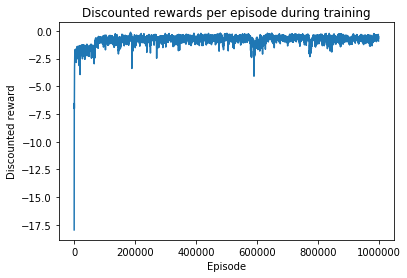

In [6]:
# Visualizing train simulation:

#episode =episodes
#simulation_id = 2
#step = 30

discrewards = pd.read_table(rewards_file, sep = ",") * 10 #we divided by the number of games per episode at running time

indices = [i for i in range(0,n_iterations,1)]

plt.plot(discrewards['iteration'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")

plt.savefig(simulation_directory + '/discounted-rewards-sim' + '{}'.format(simulation_id) + '.pdf')

plt.show()
plt.close()

# PG Testing

In [7]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 1

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 


with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
               
        env.close()
    

INFO:tensorflow:Restoring parameters from ./simulations/simulation316/NN-models/pdenv_best_policy_net_pg.ckpt


## Giff animation

In [8]:
test_anim = ut.create_system_animation(frames, n_episodes * episode_length)
plt.close()

HTML(test_anim.to_html5_video())

## Visualization with matplotlib

In [9]:
from utils_pg import is_empty
from utils_pg import my_indicator

def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    #tanks = test_toy_system.tanks
    tanks_max_load = system.tank_max_loads
    level_percentages = system.load_level_percentages

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, level_percentages[i-1]):
            plt.axhline(y= lvl * tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = level_percentages[i-1]           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks_max_load[i-1], xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length*n_episodes+1,5*n_episodes
                        ))
        
        #################### INFO LEVELS
        b = percentages[0]
        level_counts = np.zeros(5, dtype = np.int64)
        
        x_mins = np.array([0,b,c,e])*tanks_max_load[i-1]
        x_maxs = np.array([b,c,e,1])*tanks_max_load[i-1]

        for x in states:
            level_counts[0] = level_counts[0] + is_empty(x)
            for j in range(1,5):
                level_counts[j] = level_counts[j] + my_indicator(x_mins[j-1], x, x_maxs[j-1])
            
        level_counts_list.append(level_counts)
        ###################################################

    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()

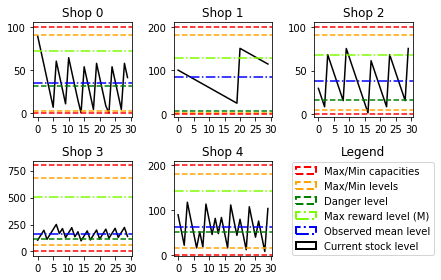

In [10]:
test_level_counts_list = []

visualize_simulation(states_file,
                        system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list = test_level_counts_list)   

## Performance metrics

INFO:tensorflow:Restoring parameters from ./simulations/simulation316/NN-models/pdenv_best_policy_net_pg.ckpt


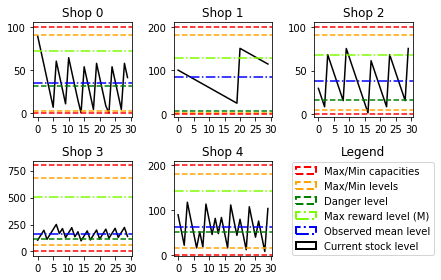

Total discounted rewards Level rewards Transport rewards
-369290.49140046333 -2021910.318404379 33658.48430999999
Average trucks sent:  42.0
Average 1st type Trucks sent to each shop: [ 6.  0.  5.  0.  5. 14.]
Average 1st type Trucks sent: 16.0
Average 2nd type Trucks sent to each shop: [ 0.  1.  0. 20.  5.  4.]
Average 2nd type Trucks sent: 26.0
Average number of trucks not deliverying: 0.0
Average level counts for shop 0: [ 2.  0. 11. 17.  0.]
Average level counts for shop 1: [ 0.  0.  0. 30.  0.]
Average level counts for shop 2: [ 0.  1.  5. 24.  0.]
Average level counts for shop 3: [ 0.  0.  3. 27.  0.]
Average level counts for shop 4: [ 0.  4. 11. 15.  0.]
Average total level counts: [  2.   5.  30. 113.   0.]
Percentage total level counts: [ 1.33333333  3.33333333 20.         75.33333333  0.        ]


In [13]:
seed = 45 # this seed determines the initialization of the system when calling env.reset() ,etc
np.random.seed(seed)

frames = []
n_episodes = 1

system = PDSystemEnv()
#model_file = "pdenv_policy_net_pg.ckpt"
test_model_file = best_model_file

with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

####
test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []
test_number_of_trucks_not_deliverying_list = []
####

with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess, test_model_file)
        for episode in range(n_episodes):
            #####
            discounted_reward = 0 
            transport_rewards = 0
            level_rewards = 0
            number_of_trucks_sent = 0
            number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)
            number_of_trucks_not_deliverying = 0                   
            #####         
         
            state = env.reset()
            for step in range(episode_length):
                system.state = state
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode)*(episode_length)+step]+state.tolist())], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',') 
                img = system.visualize()
                frames.append(img)

                action_val = test_action.eval(feed_dict={X: state.reshape(1, n_inputs)})
                #print(action_val)
                vect_action = int_to_action(action_val,env) #HERE WE CONVERT FROM INTEGER TO ACTION's Array
                #print(vect_action)
                state, reward, done, info = env.step(vect_action)
            
                trucks_not_del = info["trucks_not_deliverying"]
                level_reward = info["level_rewards"]
                transport_reward = info["transport_rewards"]
                ### STORE STEP INFO
                discounted_reward = discounted_reward + (discount_rate**(step)) * reward
                transport_rewards = transport_rewards+transport_reward
                level_rewards = level_rewards + level_reward
                
                number_of_trucks_sent = number_of_trucks_sent + np.sum(vect_action == 5)
                index1 = vect_action[0]
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = vect_action[1]
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                number_of_trucks_not_deliverying =  number_of_trucks_not_deliverying + trucks_not_del
                
            test_rewards_list.append(discounted_reward);
            test_transport_rewards_list.append(transport_rewards);
            test_level_rewards_list.append(level_rewards);
            test_trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            test_number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            test_number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);
            test_number_of_trucks_not_deliverying_list.append(number_of_trucks_not_deliverying);                   
                
               
        env.close()
        
test_level_counts_list = []

visualize_simulation(states_file,
                        system,
                        simulation_id,
                        simulation_directory,
                        level_counts_list = test_level_counts_list) 

print("Total discounted rewards","Level rewards", "Transport rewards")
print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
#     if n_episodes == 1:
first_type = sum(test_number_of_first_trucks_sent_list)/n_episodes
print("Average 1st type Trucks sent to each shop:", first_type)
print("Average 1st type Trucks sent:", sum(first_type[0:n] ) )

second_type = sum(test_number_of_second_trucks_sent_list)/n_episodes
print("Average 2nd type Trucks sent to each shop:", second_type)
print("Average 2nd type Trucks sent:",  sum(second_type[0:n] ))

print("Average number of trucks not deliverying:", sum(test_number_of_trucks_not_deliverying_list)/n_episodes )

for i in range(n):
        print("Average level counts for shop {}:".format(i), test_level_counts_list[i]/n_episodes )

        
print("Average total level counts:", sum(test_level_counts_list)/n_episodes )
print("Percentage total level counts:", (sum(test_level_counts_list)/n_episodes)/(episode_length * n) * 100 )